<h1>Salary Predictions Based on Job Descriptions</h1>

'''This notebook pulls in salary data, builds and tests several predictive models,
   and then makes salary predictions on test data using the best model.'''

__author__ = "Jennifer Ma"
__email__ = "jenniferfmma@gmail.com"

<h3>Import packages</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

In [2]:
# Input file
training_feat_file = 'data/train_features.csv'
target_df_file = 'data/train_salaries.csv'
test_features_file = 'data/test_features.csv'

# Variables
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'

def load_file(filename):
    '''load csv to pd dataframe'''
    return pd.read_csv(filename)

features_df = load_file(training_feat_file)
target_df = load_file(target_df_file)
test_df = load_file(test_features_file)

In [3]:
# Combine data
merge_train_df = pd.merge(left=features_df, right=target_df, how='inner', on='jobId', left_index=False, right_index=False)

# Clean up target df by removing salaries <= 0 as seen during EDA
raw_train_df = merge_train_df[merge_train_df.salary>0]

# Shuffle data to improve cross-validation accuracy and reindex
clean_train_df = shuffle(raw_train_df).reset_index()

clean_train_df.head()

,index,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,448120,JOB1362684855807,COMP57,CFO,BACHELORS,NONE,EDUCATION,7,71,107
1,442026,JOB1362684849713,COMP53,CEO,DOCTORAL,BIOLOGY,EDUCATION,22,5,152
2,368115,JOB1362684775802,COMP41,JUNIOR,BACHELORS,BUSINESS,FINANCE,7,37,131
3,792662,JOB1362685200349,COMP9,VICE_PRESIDENT,MASTERS,LITERATURE,EDUCATION,5,71,109
4,366807,JOB1362684774494,COMP36,MANAGER,HIGH_SCHOOL,NONE,WEB,6,81,91


In [4]:
clean_train_df.describe()

,index,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000,999995.000000
mean,499999.177092,11.992407,49.529381,116.062398
std,288675.219219,7.212390,28.877721,38.717163
min,0.000000,0.000000,0.000000,17.000000
25%,249999.500000,6.000000,25.000000,88.000000
50%,499999.000000,12.000000,50.000000,114.000000
75%,749998.500000,18.000000,75.000000,141.000000
max,999999.000000,24.000000,99.000000,301.000000


In [5]:
target_df = clean_train_df['salary']
target_df.head()

0    107
1    152
2    131
3    109
4     91
Name: salary, dtype: int64

## Part 3 - DEVELOP MODEL

Cycle through creating features, tuning models, and training/validating models until our efficacy goal of <360 MSE is reached.

### 7 : Engineer features

In [6]:
# Before modeling, categorical variables to be encoded for both the training and test data

def one_hot_encoding_df(df, cat_vars = None, num_vars = None):
    '''Perform one-hot encoding on categorical variables and combine with numerical variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis = 1)

training_feat_df = one_hot_encoding_df(clean_train_df, cat_vars = cat_cols, num_vars = num_cols)
test_feat_df = one_hot_encoding_df(test_df, cat_vars = cat_cols, num_vars = num_cols)

In [7]:
training_feat_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,7,71
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,22,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,7,37
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5,71
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,6,81


### 8 : Create and Test Models

<h3>Create and tune the models brainstormed in part 2</h3>

In [8]:
# Create Linear Regression Model
lr = LinearRegression()

# Create linear regression model with pipeline
# Standardizing data and dimensionality reduction may improve results
lr_std = make_pipeline(StandardScaler(), PCA(), LinearRegression())


The following parameters for the random forest regression model will be optimized:
- max_depth
- n_estimators
- max_features


In [9]:
# Create Random Forest Regression Model with pre-tuned parameters
rf = RandomForestRegressor(n_estimators=150, 
                           n_jobs=2, 
                           max_depth=25, 
                           max_features=30, 
                           verbose = 1)

The following parameter for gradient boosting will be optimized:
- max_depth
- n_estimators

In [10]:
# Create Gradient Boosted Regression Model with pre-tuned parameters
gbr = GradientBoostingRegressor(n_estimators=150, 
                                 max_depth=5, 
                                 loss='ls', 
                                 verbose=1)

In [11]:
# Use cross val score to evaluate MSE of each model and print a summary for each one

models = [lr, lr_std, rf, gbr]
mean_mse = {}
cv_std = {}
res = {}

def model_score(model, training_feat_df, clean_target_df, mean_mse, cv_std):
    neg_mse = cross_val_score(model, training_feat_df, clean_target_df, scoring = 'neg_mean_squared_error', cv = 3)
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('Model: \n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

print("Cross validation results:")
for model in models:
    model_score(model, training_feat_df, target_df, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Cross validation results:
Model: 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4551140184655
Standard deviation during CV:
 0.35300729605740405
Model: 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.4812905291421
Standard deviation during CV:
 0.3398725167723061


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  5.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    9.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  5.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 150

Model: 
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=2, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)
Average MSE:
 374.2425271594105
Standard deviation during CV:
 0.35460355073733363
      Iter       Train Loss   Remaining Time 
         1        1349.3547            6.92m
         2        1228.1087            6.87m
         3        1128.0105            6.83m
         4        1043.7784            6.79m
         5         973.0861            6.74m
         6         913.6354            6.69m
         7         861.0923            6.65m
         8         813.2082            6.61m
         9    

### 9 : Select best model

In [12]:
#select the model with the lowest MSE
model = min(mean_mse, key= mean_mse.get)

print("The model with the lowest MSE is:\n", model)

The model with the lowest MSE is:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)


In [14]:
test_feat_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,22,73
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,20,47
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,17,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,14,96
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,10,44


In [19]:
# use model with lowest mse to train data and make prediction on test data
model.fit(training_feat_df, target_df)
predictions = model.predict(test_feat_df)

      Iter       Train Loss   Remaining Time 
         1        1351.2830           10.78m
         2        1229.8976           10.76m
         3        1129.7084           10.69m
         4        1045.3752           10.60m
         5         974.4283           10.53m
         6         914.9446           10.46m
         7         862.6779           10.37m
         8         814.8460           10.28m
         9         772.9795           10.25m
        10         737.2014           10.20m
        20         519.7989            9.83m
        30         434.7553            8.95m
        40         397.1956            8.20m
        50         379.5808            7.55m
        60         370.1295            6.84m
        70         364.8456            6.15m
        80         361.7159            5.37m
        90         359.4911            4.59m
       100         357.9892            3.82m


In [21]:
model.feature_importances_

array([0.00000000e+00, 4.02498209e-06, 3.48089578e-06, 3.29933573e-06,
       3.82848017e-06, 8.28642735e-06, 1.72503893e-06, 4.32941832e-06,
       2.54071377e-06, 4.14408197e-06, 2.98091253e-06, 1.97406856e-06,
       3.09323626e-06, 4.32680713e-06, 5.29502998e-06, 2.35700845e-06,
       2.01408828e-06, 6.00154690e-06, 0.00000000e+00, 5.05000976e-06,
       2.01442979e-06, 3.19401067e-06, 1.04105343e-06, 7.45805377e-07,
       5.56806650e-06, 3.19476813e-06, 2.57861295e-06, 2.31183006e-06,
       5.95455060e-06, 1.90052485e-06, 8.97728039e-06, 1.04682606e-06,
       4.67929210e-06, 2.14111132e-06, 3.14154274e-06, 3.73408887e-07,
       1.27195211e-06, 4.85859804e-06, 1.14258913e-06, 4.67091047e-06,
       1.03207400e-06, 7.84342966e-06, 3.59388682e-06, 4.79407165e-06,
       1.79624380e-06, 1.04010189e-06, 8.15632597e-07, 9.32754949e-07,
       2.66407058e-06, 4.06753953e-06, 1.76178044e-06, 3.21519996e-06,
       5.77141077e-06, 3.58640523e-06, 2.63070183e-06, 2.70405927e-06,
      

In [23]:
test_feat_df.columns

Index(['companyId_COMP0', 'companyId_COMP1', 'companyId_COMP10',
       'companyId_COMP11', 'companyId_COMP12', 'companyId_COMP13',
       'companyId_COMP14', 'companyId_COMP15', 'companyId_COMP16',
       'companyId_COMP17', 'companyId_COMP18', 'companyId_COMP19',
       'companyId_COMP2', 'companyId_COMP20', 'companyId_COMP21',
       'companyId_COMP22', 'companyId_COMP23', 'companyId_COMP24',
       'companyId_COMP25', 'companyId_COMP26', 'companyId_COMP27',
       'companyId_COMP28', 'companyId_COMP29', 'companyId_COMP3',
       'companyId_COMP30', 'companyId_COMP31', 'companyId_COMP32',
       'companyId_COMP33', 'companyId_COMP34', 'companyId_COMP35',
       'companyId_COMP36', 'companyId_COMP37', 'companyId_COMP38',
       'companyId_COMP39', 'companyId_COMP4', 'companyId_COMP40',
       'companyId_COMP41', 'companyId_COMP42', 'companyId_COMP43',
       'companyId_COMP44', 'companyId_COMP45', 'companyId_COMP46',
       'companyId_COMP47', 'companyId_COMP48', 'companyId_COMP49',


In [24]:
# access feature importance of model with lowest mse
feature_importance = pd.DataFrame({'feature': test_feat_df.columns, 'importance': model.feature_importances_})
feature_importance.sort_values(by='importance', ascending = False, inplace = True)

# set index to 'feature'
feature_importance.set_index('feature', inplace = True, drop = True)

In [25]:
# save information to file
with open('model.txt', 'w') as file:
    file.write(str(model))
    
feature_importance.to_csv('feature_importance.csv')

# Save predictions to file
np.savetxt('predictions.csv', predictions, delimiter=',')

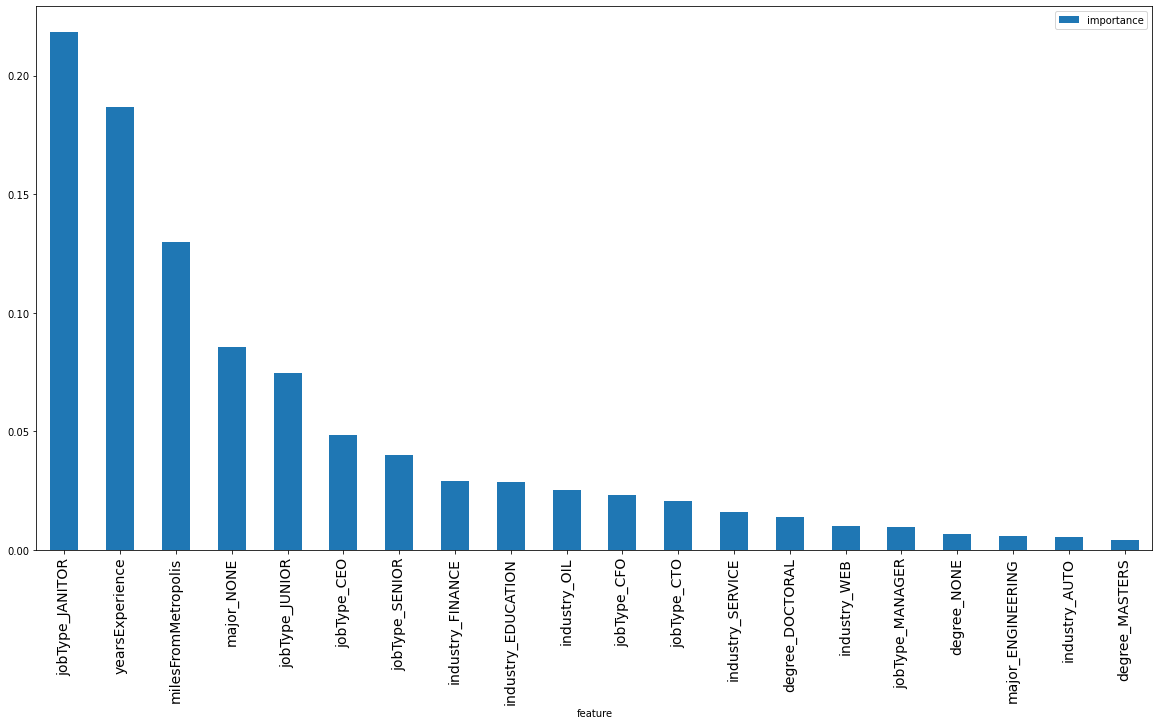

In [31]:
# Plot feature importance
feature_importance[:20].plot.bar(figsize=(20, 10))
plt.xticks(fontsize = 14)
plt.show()

In [33]:
feature_importance.head(10)

,importance
feature,
jobType_JANITOR,0.218285
yearsExperience,0.186719
milesFromMetropolis,0.129771
major_NONE,0.085625
jobType_JUNIOR,0.074764
jobType_CEO,0.048494
jobType_SENIOR,0.040219
industry_FINANCE,0.028979
industry_EDUCATION,0.028569


In [34]:
!head predictions.csv

1.112319470299438109e+02
9.358076805149475774e+01
1.789313055117166016e+02
1.043686516871983514e+02
1.170745237113808486e+02
1.507164339871137599e+02
9.642931186092526730e+01
1.185500271711061941e+02
1.069490341265069731e+02
9.826842079587639489e+01


## Part 4 - DEPLOY

### 10 : Automate pipeline

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [36]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders
salary_pred_file = 'predictions.csv'
salary_pred_df = pd.read_csv(salary_pred_file, header=None)
salary_pred_df.head()

,0
0,111.231947
1,93.580768
2,178.931306
3,104.368652
4,117.074524


In [39]:
# Combine test data with the predicted salaries
test_df['Predicted Salary']= salary_pred_df.iloc[:,0]
test_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,Predicted Salary
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,111.231947
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,93.580768
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,178.931306
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,104.368652
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,117.074524


In [40]:
# Save data
test_df.to_csv('Test Features with Predicted Salary.csv')